In [1]:
import numpy as np

import json

from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

#### First we will find out the coordinates of Visakhapatnam

In [2]:
from geopy.geocoders import Nominatim

In [3]:
geolocator = Nominatim(user_agent = "Explore_Vizag")
location = geolocator.geocode('Visakhapatnam,Andhra Pradesh')

In [4]:
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Visakhapatnam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Visakhapatnam are 17.7231276, 83.3012842.


In [5]:
import pandas as pd

##### I prepared the dataset: 
##### https://github.com/Jahnavi-Mantripragada/Coursera_Capstone/blob/master/neighbourhood_data_Visakhapatnam.csv, 
##### please do have a look at the code which i used to make it, 
##### https://github.com/Jahnavi-Mantripragada/Coursera_Capstone/blob/master/Neighbourhood_Data_Collection.ipynb

In [6]:
vizag_df = pd.read_csv("neighbourhood_data_Visakhapatnam.csv")

In [7]:
vizag_df.head()

,Neighbourhood,Latitude,Longitude
0,Abidnagar,17.558513,79.134943
1,Adarsh Nagar,30.104309,78.288169
2,Adavivaram,17.777825,83.250659
3,Aganampudi,17.686012,83.135476
4,Akkayyapalem,17.727487,83.299088


### Plotting these neighbourhoods on the map:

In [8]:
map_vizag = folium.Map(location=[latitude, longitude], zoom_start=15)
# add markers to map
for lat, lng, neighbourhood in zip(vizag_df['Latitude'], vizag_df['Longitude'], vizag_df['Neighbourhood']):
    label = neighbourhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vizag)  
    
map_vizag

#### To make use of Foursquare API

In [9]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


##### In this we are going to use "explore" endpoint in the url (Requesting API for information)

In [10]:
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [11]:
import requests

##### The API returns a json file

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebfac55963d29001b37b638'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Vizag',
  'headerFullLocation': 'Vizag',
  'headerLocationGranularity': 'city',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 17.73212760900001,
    'lng': 83.31071500332936},
   'sw': {'lat': 17.714127590999993, 'lng': 83.29185339667063}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e4551f5e4cd9d94fb124d7e',
       'name': 'Sangam Sarat Theatre',
       'location': {'lat': 17.72550838780179,
        'lng': 83.30246344993398,
        'labeledLatLngs': [{'label': 'display',
          'lat': 17.72550838780179,
          'lng': 83.30246344993398}],
        

#### We are going to extract the required information such as the venue and it's data

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

##### Here we would be storing them in a dataframe

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Sangam Sarat Theatre,Indie Movie Theater,17.725508,83.302463
1,Sai Ram Parlour,Indian Restaurant,17.726339,83.303465
2,Pizza Hut,Pizza Place,17.726650,83.305531
3,Pages,Bookstore,17.719736,83.306753
4,Green Park Hotel Visakhapatnam,Hotel,17.715709,83.306315


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:

v_venues = getNearbyVenues(names=vizag_df['Neighbourhood'],
                                   latitudes=vizag_df['Latitude'],
                                   longitudes=vizag_df['Longitude']
                                  )

Abidnagar
Adarsh Nagar
Adavivaram
Aganampudi
Akkayyapalem
Allipuram
Anakapalle
Anandapuram
Arilova
Asilmetta
Atchutapuram
Beach Road
Bheemunipatnam
Chinna Gadhili
Chinna Waltair
Daba Gardens
Daspalla Hills
Devada
Devipuram
Duvvada
Dwaraka Nagar
Gajuwaka
Gambhiram
Gangavaram
Gopalapatnam
Gudilova
Hanumanthavaka
HB Colony
Jagadamba Centre
Jalari Peta
Kailasapuram
Kakani Nagar
Kancharapalem
Kommadi
Kurmannapalem
Lankelapalem
Lawsons Bay Colony
Maddilapalem
Malkapuram
Marripalem
Mindi
Mulagada
MVP Colony
NAD X Road
Nadupuru
Naidu Thota
Narava
Nathayyapalem
Nidigattu
Padmanabham
Parawada
Pedagantyada
Pendurthi
Poorna Market
Prahaladapuram
Prakashraopeta
Pudimadaka
Railway New Colony
Ramnagar
Ravada
Ravindra Nagar
Relli Veedhi
Rushikonda
Sabbavaram
Sagar Nagar
Salipeta
Sankara Matam Road
Scindia
Seethammadhara
Sheela Nagar
Siripuram
Sontyam
Sriharipuram
Sujatha Nagar
Tagarapuvalasa
Thatichetlapalem
Town Kotha Road
Vadlapudi
Velampeta
Venkojipalem
Vepagunta
VIP Road
Visalakshi Nagar
Waltair M

##### Here we get a list of venues in the neighbourhood

In [17]:
print(v_venues.shape)
v_venues.head()

(235, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,30.104309,78.288169,Dezloper,30.107285,78.287823,IT Services
1,Adarsh Nagar,30.104309,78.288169,Sitting Elephant Restaurant,30.101748,78.291772,Restaurant
2,Adarsh Nagar,30.104309,78.288169,Ellbee Ganga View,30.101624,78.291794,Hotel
3,Adarsh Nagar,30.104309,78.288169,Rishikesh Market,30.106958,78.292262,Plaza
4,Aganampudi,17.686012,83.135476,Domino's Pizza,17.686542,83.139156,Pizza Place


In [18]:
v_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adarsh Nagar,4,4,4,4,4,4
Aganampudi,2,2,2,2,2,2
Akkayyapalem,5,5,5,5,5,5
Anakapalle,3,3,3,3,3,3
Arilova,2,2,2,2,2,2
Asilmetta,6,6,6,6,6,6
Beach Road,3,3,3,3,3,3
Bheemunipatnam,3,3,3,3,3,3
Chinna Gadhili,1,1,1,1,1,1


In [19]:
print('There are {} uniques categories.'.format(len(v_venues['Venue Category'].unique())))

There are 81 uniques categories.


##### Here encoding is done to get what all categories are present in each neighbourhood

In [20]:
# one hot encoding
v_onehot = pd.get_dummies(v_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
v_onehot['Neighborhood'] = v_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [v_onehot.columns[-1]] + list(v_onehot.columns[:-1])
v_onehot = v_onehot[fixed_columns]

v_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,American Restaurant,Andhra Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Spa,Sporting Goods Shop,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aganampudi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Here i chose only the places where people can enjoy or to be precise are likely to spend a holiday

In [21]:
v_onehot.columns
places_to_spend = [ 'Neighborhood',
       'American Restaurant', 'Andhra Restaurant', 'Asian Restaurant',
       'BBQ Joint', 'Bakery', 'Bed & Breakfast','Breakfast Spot', 'Cafeteria', 'Café',
       'Coffee Shop', 'Comfort Food Restaurant', 'Dessert Shop',
       'Dhaba', 'Diner','Fast Food Restaurant', 'Food Court','Food Truck', 
       'Historic Site', 'Hot Dog Joint', 'Hotel','Ice Cream Shop', 
       'Indian Restaurant', 'Indie Movie Theater','Italian Restaurant', 
       'Juice Bar','Lounge','Middle Eastern Restaurant', 'Motel',
       'Movie Theater', 'Moving Target', 'Multiplex', 'Park', 
       'Pizza Place', 'Plaza', 'Resort', 'Restaurant',
       'Sandwich Place', 'Scenic Lookout', 'Seafood Restaurant',
       'Shopping Mall', 'Snack Place', 'Vegetarian / Vegan Restaurant']
v_places = v_onehot[places_to_spend]
v_places.loc[v_places["Neighborhood"]=="Beach Road"]

,Neighborhood,American Restaurant,Andhra Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Breakfast Spot,Cafeteria,Café,...,Pizza Place,Plaza,Resort,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Vegetarian / Vegan Restaurant
22,Beach Road,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,Beach Road,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,Beach Road,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
v_group = v_places.groupby('Neighborhood').mean().reset_index()
v_group

,Neighborhood,American Restaurant,Andhra Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Breakfast Spot,Cafeteria,Café,...,Pizza Place,Plaza,Resort,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Vegetarian / Vegan Restaurant
0,Adarsh Nagar,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.25,0.000000,0.250000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
1,Aganampudi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
2,Akkayyapalem,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.2
3,Anakapalle,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
4,Arilova,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
5,Asilmetta,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
6,Beach Road,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
7,Bheemunipatnam,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.333333,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
8,Chinna Gadhili,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
9,Chinna Waltair,0.0,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.142857,0.0


#### Here we are looking at top 5 venues in each neighbourhood

In [23]:
num_top_venues = 5

for hood in v_group['Neighborhood']:
    print("----"+hood+"----")
    temp = v_group[v_group['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adarsh Nagar----
                 venue  freq
0                Hotel  0.25
1           Restaurant  0.25
2                Plaza  0.25
3  American Restaurant  0.00
4            Multiplex  0.00


----Aganampudi----
                venue  freq
0         Pizza Place   0.5
1                Park   0.0
2  Italian Restaurant   0.0
3           Juice Bar   0.0
4              Lounge   0.0


----Akkayyapalem----
                           venue  freq
0              Indian Restaurant   0.4
1                          Hotel   0.2
2            Indie Movie Theater   0.2
3  Vegetarian / Vegan Restaurant   0.2
4                         Bakery   0.0


----Anakapalle----
                 venue  freq
0  Indie Movie Theater  0.33
1                 Park  0.00
2   Italian Restaurant  0.00
3            Juice Bar  0.00
4               Lounge  0.00


----Arilova----
                 venue  freq
0  American Restaurant   0.0
1                 Park   0.0
2   Italian Restaurant   0.0
3            Juice Bar   0.0
4

#### ELBOW METHOD: [took help from: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/]

In [24]:
from scipy.spatial.distance import cdist 
from sklearn import metrics 
import matplotlib.pyplot as plt  
v_group_clustering = v_group.drop('Neighborhood', 1)
X = v_group_clustering
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

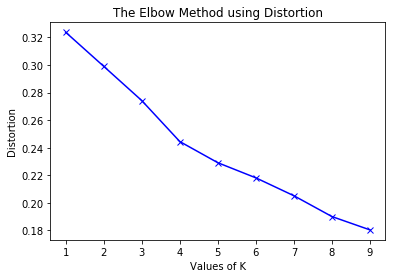

In [25]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

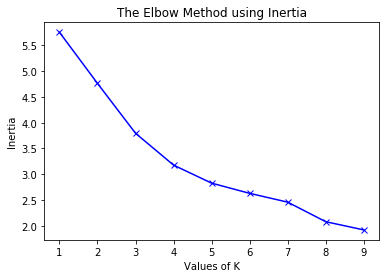

In [26]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

####  Here, inertia method is giving us a better idea of elbow point, and the elbow point is at "4"

In [27]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(v_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 2, 0, 0, 3, 2])

##### Now we add 10 most common venues in that neighbourhood

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = v_group['Neighborhood']

for ind in np.arange(v_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(v_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Restaurant,Plaza,Hotel,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner
1,Aganampudi,Pizza Place,Vegetarian / Vegan Restaurant,Coffee Shop,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
2,Akkayyapalem,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Indie Movie Theater,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba
3,Anakapalle,Indie Movie Theater,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
4,Arilova,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Hot Dog Joint,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop


In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

v_merged = vizag_df


v_merged = v_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
v_merged.dropna(inplace=True)
v_merged.reset_index(drop=True,inplace=True)
v_merged

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,30.104309,78.288169,0.0,Restaurant,Plaza,Hotel,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner
1,Aganampudi,17.686012,83.135476,0.0,Pizza Place,Vegetarian / Vegan Restaurant,Coffee Shop,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
2,Akkayyapalem,17.727487,83.299088,2.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Indie Movie Theater,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba
3,Anakapalle,17.688970,83.003476,0.0,Indie Movie Theater,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
4,Arilova,17.767525,83.313898,0.0,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Hot Dog Joint,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
5,Asilmetta,17.723626,83.308411,2.0,Indian Restaurant,Pizza Place,Hotel,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner
6,Beach Road,17.725861,83.338842,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Hot Dog Joint,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba
7,Bheemunipatnam,17.891381,83.451218,0.0,Resort,Hotel,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba
8,Chinna Gadhili,17.759925,83.316203,3.0,Moving Target,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
9,Chinna Waltair,17.724499,83.331658,2.0,Bed & Breakfast,Snack Place,Indian Restaurant,Food Truck,Juice Bar,Dessert Shop,Historic Site,Food Court,Fast Food Restaurant,Diner


### Now we plot out the map:

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(v_merged['Latitude'], v_merged['Longitude'], v_merged['Neighbourhood'], v_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    except:
        pass
       
map_clusters

### now let's look into and understand which places are good to visit

In [32]:
v_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,30.104309,78.288169,0.0,Restaurant,Plaza,Hotel,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner
1,Aganampudi,17.686012,83.135476,0.0,Pizza Place,Vegetarian / Vegan Restaurant,Coffee Shop,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
2,Akkayyapalem,17.727487,83.299088,2.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Indie Movie Theater,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba
3,Anakapalle,17.688970,83.003476,0.0,Indie Movie Theater,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop
4,Arilova,17.767525,83.313898,0.0,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Hot Dog Joint,Historic Site,Food Truck,Food Court,Fast Food Restaurant,Diner,Dhaba,Dessert Shop


In [33]:
v_merged.groupby(["Cluster Labels"]).count()[["Neighbourhood"]]

,Neighbourhood
Cluster Labels,
0.0,30
1.0,1
2.0,9
3.0,1


### We can say that 30 places in Vizag have a cluster of restaurants, coffee shops, movie theatres and much more!!

##### Now let's look at those 30 places:

In [34]:
spend_a_holiday = v_merged.loc[v_merged["Cluster Labels"]==0.0][["Neighbourhood","Latitude","Longitude","Cluster Labels"]]
print(spend_a_holiday.shape[0])
spend_a_holiday

30


,Neighbourhood,Latitude,Longitude,Cluster Labels
0,Adarsh Nagar,30.104309,78.288169,0.0
1,Aganampudi,17.686012,83.135476,0.0
3,Anakapalle,17.688970,83.003476,0.0
4,Arilova,17.767525,83.313898,0.0
6,Beach Road,17.725861,83.338842,0.0
7,Bheemunipatnam,17.891381,83.451218,0.0
10,Daspalla Hills,17.437015,78.398429,0.0
11,Devipuram,8.557120,76.929593,0.0
12,Duvvada,17.703598,83.151376,0.0
13,Gambhiram,17.879537,83.370890,0.0


##### Second Best place:

In [35]:
v_merged.loc[v_merged["Cluster Labels"]==1.0][["Neighbourhood","Latitude","Longitude","Cluster Labels"]]

,Neighbourhood,Latitude,Longitude,Cluster Labels
14,Hanumanthavaka,17.754883,83.33226,1.0


#### Next Best Places

In [36]:
v_merged.loc[v_merged["Cluster Labels"]==2.0][["Neighbourhood","Latitude","Longitude","Cluster Labels"]]

,Neighbourhood,Latitude,Longitude,Cluster Labels
2,Akkayyapalem,17.727487,83.299088,2.0
5,Asilmetta,17.723626,83.308411,2.0
9,Chinna Waltair,17.724499,83.331658,2.0
23,MVP Colony,17.742265,83.335686,2.0
25,Ramnagar,17.723128,83.301284,2.0
26,Relli Veedhi,17.725311,83.330510,2.0
27,Rushikonda,17.778570,83.382108,2.0
32,Sujatha Nagar,18.491026,73.825498,2.0
35,Venkojipalem,17.747575,83.331564,2.0


##### Not so likely to visit

In [37]:
v_merged.loc[v_merged["Cluster Labels"]==3.0][["Neighbourhood","Latitude","Longitude","Cluster Labels"]]

,Neighbourhood,Latitude,Longitude,Cluster Labels
8,Chinna Gadhili,17.759925,83.316203,3.0


##### Thank YOU!